<a href="https://colab.research.google.com/github/bbanzai88/Learning_ABM_From_Data/blob/main/abm_sp500_forecast_compare_cmaes_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S&P 500 Forecasting: Agent‑Based Model vs. Classical Time‑Series

This notebook downloads **S&P 500** data, calibrates a **market ABM** by **Method of Simulated Moments (MSM)**, and compares probabilistic forecasts against classical approaches:

- **ABM (fundamentalists + chartists + noise)**
- **Random Walk with drift**
- **ARIMA** (small grid search by AIC)
- **Exponential Smoothing (ETS)** on log‑price

It supports three optimizers for ABM calibration:
- **Differential Evolution (DE)**
- **CMA‑ES** (via `cma`)
- **Bayesian Optimization** (via `optuna`)

We evaluate **point‑forecast accuracy** (RMSE/MAE) and **probabilistic coverage** of **50%** and **90%** intervals.

> **Disclaimer:** Educational use only. Not investment advice.

In [1]:
# --- Config ---
TICKER = '^GSPC'  # S&P 500 index
START  = '2005-01-01'
END    = None      # None = today

# Train/test split and horizon
TEST_H = 40         # forecast horizon (trading days)
MIN_TRAIN = 750     # minimum training length (trading days)

# ABM calibration & forecast knobs
ABM_MSM_RUNS   = 5     # runs for moment estimation during fit (higher => slower, less noisy)
ABM_MC_PATHS   = 500   # Monte Carlo paths for forecast intervals
ABM_CONF_LEVELS = [0.50, 0.90]

# Optimizer toggles and budgets
USE_DE      = True
USE_CMAES   = True
USE_OPTUNA  = True

DE_MAXITER  = 25
DE_POPSIZE  = 20

CMA_ITERS   = 1500      # function evaluations budget (not generations)
CMA_SIGMA0  = 0.3       # initial step size in normalized space

OPTUNA_TRIALS = 60

# ARIMA grid (small)
AR_PQ = [0,1,2]
AR_D  = [0,1]

SEED = 7

In [2]:
# --- Dependencies ---
import sys, subprocess
def pip_install(p):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', p])

for pkg in [
    'yfinance',
    'numpy', 'pandas', 'matplotlib', 'scipy', 'statsmodels', 'tqdm',
    'cma', 'optuna'
]:
    try:
        __import__(pkg.split('==')[0])
    except Exception:
        pip_install(pkg)
print('✅ Dependencies ready')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange
from numpy.linalg import norm
from scipy.optimize import differential_evolution
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import yfinance as yf
import optuna
import cma
np.set_printoptions(suppress=True)

✅ Dependencies ready


## Download and prepare data

In [3]:
if END is None:
    END = pd.Timestamp.today().strftime('%Y-%m-%d')

raw = yf.download(TICKER, start=START, end=END, auto_adjust=True, progress=False)
if 'Adj Close' in raw.columns:
    price = raw['Adj Close'].dropna().astype(float)
else:
    price = raw['Close'].dropna().astype(float)

price = price[price>0]
logp = np.log(price.values)
ret  = np.diff(logp)
dates = price.index
print('Obs:', len(price), 'Train>=', MIN_TRAIN, '| Horizon:', TEST_H)

assert len(price) >= MIN_TRAIN + TEST_H, 'Not enough data; reduce TEST_H or MIN_TRAIN or extend START.'
train_end = -TEST_H
train_price = price.iloc[:train_end]
test_price  = price.iloc[train_end:]
train_logp  = np.log(train_price.values)
train_ret   = np.diff(train_logp)
test_logp   = np.log(test_price.values)
test_ret    = np.diff(test_logp)
print('Train:', len(train_price), 'Test:', len(test_price))

Obs: 5189 Train>= 750 | Horizon: 40
Train: 5149 Test: 40


In [8]:
# Ensure Series → 1-D arrays
train_logp = np.log(np.asarray(train_price, dtype=float).ravel())
test_logp  = np.log(np.asarray(test_price,  dtype=float).ravel())

train_ret = np.diff(train_logp)
test_ret  = np.diff(test_logp)

print("train_logp shape:", train_logp.shape, "train_ret shape:", train_ret.shape)
assert train_ret.ndim == 1 and train_ret.size > 5, "train_ret is empty or not 1-D — check your price selection."

# Now compute moments safely
emp_mom = moments_from_returns(train_ret)
emp_vec = moments_vectorize(emp_mom)
print("emp_vec:", emp_vec)


train_logp shape: (5149,) train_ret shape: (5148,)
emp_vec: [ 0.01219178 13.04337435 -0.1212774   0.30245159]


## Moments & utilities

In [9]:
import numpy as np

def _to_1d(x):
    x = np.asarray(x, dtype=float)
    return x.ravel()  # always 1-D

def kurtosis_excess(x):
    x = _to_1d(x)
    x = x[np.isfinite(x)]
    if x.size < 2:
        return np.nan
    mu = x.mean()
    xc = x - mu
    m2 = np.mean(xc * xc)
    if m2 <= 0 or not np.isfinite(m2):
        return np.nan
    m4 = np.mean(xc**4)
    return (m4 / (m2**2)) - 3.0

def acf(x, max_lag):
    x = _to_1d(x)
    if x.size == 0:
        return np.full(max_lag, np.nan, dtype=float)
    x = x - np.nanmean(x)
    # If all values are the same, denominator is zero → undefined ACF
    denom = float(np.dot(x, x))
    if denom == 0 or not np.isfinite(denom):
        return np.full(max_lag, np.nan, dtype=float)

    out = []
    n = x.size
    for lag in range(1, max_lag + 1):
        if lag >= n:
            out.append(np.nan)
        else:
            out.append(float(np.dot(x[:-lag], x[lag:]) / denom))
    return np.array(out, dtype=float)

def moments_from_returns(r, acf_abs_L=20):
    r = _to_1d(r)
    r = r[np.isfinite(r)]
    m = {}
    if r.size == 0:
        # return NaNs so the caller can decide how to handle
        m['std']  = np.nan
        m['kurt'] = np.nan
        m['acf1'] = np.nan
        m['acf_abs_mean_1_20'] = np.nan
        return m
    m['std']  = float(np.std(r))
    m['kurt'] = float(kurtosis_excess(r))
    ac1 = acf(r, 1)[0]
    m['acf1'] = float(ac1)
    ac_abs = acf(np.abs(r), acf_abs_L)
    m['acf_abs_mean_1_20'] = float(np.nanmean(ac_abs))
    return m

def moments_vectorize(m):
    return np.array([m['std'], m['kurt'], m['acf1'], m['acf_abs_mean_1_20']], dtype=float)


## Market ABM and MSM objective

In [10]:
# ABM: fundamentalists + chartists + noise; market maker updates log-price by excess demand / depth
def simulate_market_abm(T, p0, params, seed=0):
    rng = np.random.default_rng(seed)
    a_f, a_c, sigma_n, lam, mu_f, w_f, w_c = params
    w_f = float(np.clip(w_f, 0, 0.98))
    w_c = float(np.clip(w_c, 0, 0.98 - w_f))
    w_n = max(1e-6, 1.0 - w_f - w_c)
    logp = np.empty(T+1)
    logp[0] = np.log(p0)
    f = logp[0]
    for t in range(T):
        # evolve fundamental
        f = f + mu_f + rng.normal(0, 1e-4)
        # demands
        trend = (0.0 if t == 0 else (logp[t] - logp[t-1]))
        D_f = a_f * (f - logp[t])
        D_c = a_c * trend
        D_n = sigma_n * rng.normal(0, 1.0)
        excess = w_f*D_f + w_c*D_c + w_n*D_n
        logp[t+1] = logp[t] + excess/max(lam, 1e-6)
    r = np.diff(logp)
    return np.exp(logp), r

def simulated_moments(params, T, p0, R=5, seed=123):
    rng = np.random.default_rng(seed)
    moms = []
    for i in range(R):
        _, r = simulate_market_abm(T, p0, params, seed=int(rng.integers(0, 1_000_000)))
        moms.append(moments_from_returns(r))
    keys = moms[0].keys()
    out = {k: float(np.nanmean([m[k] for m in moms])) for k in keys}
    return out

# MSM loss
bounds = [
    (1e-4, 2.0),   # a_f
    (1e-4, 2.0),   # a_c
    (1e-4, 1.0),   # sigma_n
    (0.1, 50.0),   # lam
    (-1e-3, 1e-3), # mu_f
    (0.0, 0.95),   # w_f
    (0.0, 0.95),   # w_c (w_n = 1 - w_f - w_c)
]

w_mom = np.array([1.0, 0.25, 4.0, 1.0])
scale = np.where(emp_vec != 0, np.abs(emp_vec), 1.0)

def msm_objective(theta, R=ABM_MSM_RUNS):
    a_f, a_c, sigma_n, lam, mu_f, w_f, w_c = theta
    if (w_f < 0) or (w_c < 0) or (w_f + w_c >= 1.0):
        return 1e6
    sim_m = simulated_moments(theta, T=len(train_ret), p0=train_price.iloc[0], R=R)
    sim_vec = moments_vectorize(sim_m)
    diff = (sim_vec - emp_vec)/scale
    return float(np.sqrt(np.sum(w_mom * diff*diff)))

np.random.seed(SEED)
print('✅ ABM + MSM objective ready')

✅ ABM + MSM objective ready


## Calibrate ABM (DE, CMA‑ES, Optuna)

In [11]:
best = {}

if USE_DE:
    result_de = differential_evolution(
        lambda x: msm_objective(x, R=ABM_MSM_RUNS),
        bounds=bounds, seed=SEED, maxiter=DE_MAXITER, popsize=DE_POPSIZE, tol=1e-6, polish=True, disp=True
    )
    best['DE'] = (result_de.x, result_de.fun)
    print('DE -> loss', result_de.fun, 'theta', result_de.x)

if USE_CMAES:
    # Normalize parameters to [0,1] and map inside objective to actual space, enforcing w_f + w_c <= 1 - eps
    eps = 0.02
    lb = np.array([b[0] for b in bounds])
    ub = np.array([b[1] for b in bounds])
    def to_real(u):
        u = np.clip(u, 0, 1)
        theta = lb + u*(ub - lb)
        # enforce weights via soft constraints: compress to sum<=1-eps
        wf, wc = theta[5], theta[6]
        s = max(wf + wc, 1e-12)
        if s > 1 - eps:
            wf = wf*(1 - eps)/s
            wc = wc*(1 - eps)/s
        theta[5], theta[6] = wf, wc
        return theta
    def obj_cma(u):
        return msm_objective(to_real(u), R=ABM_MSM_RUNS)
    x0 = np.full(len(bounds), 0.5)
    es = cma.CMAEvolutionStrategy(x0, CMA_SIGMA0, {'bounds':[0.0, 1.0], 'seed':SEED, 'maxfevals':CMA_ITERS})
    while not es.stop():
        X = es.ask()
        es.tell(X, [obj_cma(x) for x in X])
    u_best = es.result.xbest
    theta_cma = to_real(u_best)
    loss_cma = msm_objective(theta_cma, R=ABM_MSM_RUNS)
    best['CMA-ES'] = (theta_cma, loss_cma)
    print('CMA-ES -> loss', loss_cma, 'theta', theta_cma)

if USE_OPTUNA:
    def optuna_objective(trial):
        a_f = trial.suggest_float('a_f', *bounds[0])
        a_c = trial.suggest_float('a_c', *bounds[1])
        sigma_n = trial.suggest_float('sigma_n', *bounds[2])
        lam = trial.suggest_float('lam', *bounds[3])
        mu_f = trial.suggest_float('mu_f', *bounds[4])
        w_f = trial.suggest_float('w_f', 0.0, 0.95)
        w_c = trial.suggest_float('w_c', 0.0, 0.95 - w_f)  # ensure sum<=0.95
        theta = np.array([a_f, a_c, sigma_n, lam, mu_f, w_f, w_c])
        return msm_objective(theta, R=ABM_MSM_RUNS)
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(optuna_objective, n_trials=OPTUNA_TRIALS, show_progress_bar=False)
    theta_opt = np.array([
        study.best_params['a_f'], study.best_params['a_c'], study.best_params['sigma_n'],
        study.best_params['lam'], study.best_params['mu_f'], study.best_params['w_f'], study.best_params['w_c']
    ])
    loss_opt = study.best_value
    best['Optuna'] = (theta_opt, loss_opt)
    print('Optuna -> loss', loss_opt, 'theta', theta_opt)

best

/tmp/ipython-input-3453161242.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  logp[0] = np.log(p0)


differential_evolution step 1: f(x)= 1.1633225734123316


/tmp/ipython-input-3453161242.py:20: RuntimeWarning: overflow encountered in scalar divide
  logp[t+1] = logp[t] + excess/max(lam, 1e-6)
/tmp/ipython-input-3453161242.py:19: RuntimeWarning: invalid value encountered in scalar add
  excess = w_f*D_f + w_c*D_c + w_n*D_n
/tmp/ipython-input-3453161242.py:22: RuntimeWarning: overflow encountered in exp
  return np.exp(logp), r
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/tmp/ipython-input-1819995146.py:14: RuntimeWarning: overflow encountered in multiply
  m2 = np.mean(xc * xc)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipython-input-1819995146.py:55: RuntimeWarning: Mean of empty slice
  m['acf_abs_mean_1_20'] = float(np.nanmean(ac_abs))
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py

differential_evolution step 2: f(x)= 1.1633225734123316
differential_evolution step 3: f(x)= 1.1633225734123316
differential_evolution step 4: f(x)= 1.1633225734123316
differential_evolution step 5: f(x)= 1.1599763732938644
differential_evolution step 6: f(x)= 1.1524079700124992
differential_evolution step 7: f(x)= 1.130661018998316
differential_evolution step 8: f(x)= 1.130661018998316
differential_evolution step 9: f(x)= 1.1278279740233101
differential_evolution step 10: f(x)= 1.11697873478075
differential_evolution step 11: f(x)= 1.11697873478075
differential_evolution step 12: f(x)= 1.11697873478075
differential_evolution step 13: f(x)= 1.11697873478075
differential_evolution step 14: f(x)= 1.11697873478075
differential_evolution step 15: f(x)= 1.1124808865800635
differential_evolution step 16: f(x)= 1.1124808865800635
differential_evolution step 17: f(x)= 1.1124808865800635
differential_evolution step 18: f(x)= 1.1124808865800635
differential_evolution step 19: f(x)= 1.11212717022

/usr/local/lib/python3.12/dist-packages/cma/utilities/utils.py:362: UserWarning: function values with index [6]/[] are nan/None and will be set to the median value 2.5184467985933052 (time=Aug 19 17:22:07 2025 class=CMAEvolutionStrategy method=ask)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.12/dist-packages/cma/utilities/utils.py:362: UserWarning: function values with index [1, 6]/[] are nan/None and will be set to the median value 2.519476247453902 (time=Aug 19 17:22:12 2025 class=CMAEvolutionStrategy method=ask iteration=5)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.12/dist-packages/cma/utilities/utils.py:362: UserWarning: function values with index [0, 1]/[] are nan/None and will be set to the median value 2.379562092100496 (time=Aug 19 17:22:16 2025 class=CMAEvolutionStrategy method=ask iteration=9)
  warnings.warn(msg + ' (time={}'.format(time.asctime()[4:]) +
/usr/local/lib/python3.12/dist-packa

CMA-ES -> loss 1.1118783054141246 theta [ 1.45430665  0.25718432  0.37850926  4.84948101 -0.00003387  0.83658615
  0.01684734]


[I 2025-08-19 17:25:18,741] Trial 1 finished with value: 2.3013140097578115 and parameters: {'a_f': 0.1441950616061871, 'a_c': 0.5369511163057321, 'sigma_n': 0.4999325125754774, 'lam': 33.99357680643493, 'mu_f': 0.000607478072208751, 'w_f': 0.36189407649111144, 'w_c': 0.038777556189899774}. Best is trial 1 with value: 2.3013140097578115.
[I 2025-08-19 17:25:18,859] Trial 2 finished with value: 3.051952743814513 and parameters: {'a_f': 0.5763623840560563, 'a_c': 1.8191960960864553, 'sigma_n': 0.2134640150445575, 'lam': 22.660985694702386, 'mu_f': 0.0008624120393780435, 'w_f': 0.02365426617283061, 'w_c': 0.5563159276474148}. Best is trial 1 with value: 2.3013140097578115.
[I 2025-08-19 17:25:18,985] Trial 3 finished with value: 2.34616579010198 and parameters: {'a_f': 1.9002639878772498, 'a_c': 0.4606827277540275, 'sigma_n': 0.5485350702441067, 'lam': 45.46550590684789, 'mu_f': -0.0007336611084814996, 'w_f': 0.4972419516400775, 'w_c': 0.33975410327708166}. Best is trial 1 with value: 2.3

Optuna -> loss 1.147451964761644 theta [1.99571579 1.5153899  0.73779791 7.85098022 0.00040843 0.90069888
 0.00401265]


{'DE': (array([ 1.805386  ,  0.08761475,  0.57081115,  6.06871404, -0.0000393 ,
          0.84106114,  0.03725657]),
  1.11188553144916),
 'CMA-ES': (array([ 1.45430665,  0.25718432,  0.37850926,  4.84948101, -0.00003387,
          0.83658615,  0.01684734]),
  1.1118783054141246),
 'Optuna': (array([1.99571579, 1.5153899 , 0.73779791, 7.85098022, 0.00040843,
         0.90069888, 0.00401265]),
  1.147451964761644)}

## Choose best calibration & forecast with ABM (Monte Carlo)

In [12]:
label_best = min(best.keys(), key=lambda k: best[k][1])
theta_hat, loss_hat = best[label_best]
print('Best optimizer:', label_best, '| loss:', loss_hat)

H = TEST_H
p0 = float(train_price.iloc[-1])
rng = np.random.default_rng(SEED)
paths = []
rets  = []
for i in trange(ABM_MC_PATHS, desc='ABM MC'):
    sp, sr = simulate_market_abm(H, p0, theta_hat, seed=int(rng.integers(0, 1_000_000)))
    paths.append(sp)
    rets.append(sr)
paths = np.stack(paths, axis=0)  # (P, H+1)
rets  = np.stack(rets,  axis=0)  # (P, H)

abm_price_median = np.median(paths, axis=0)
abm_ret_median   = np.median(rets, axis=0)

def quantiles(arr, q):
    return np.quantile(arr, q, axis=0)

abm_intervals = {}
for cl in ABM_CONF_LEVELS:
    alpha = 1 - cl
    lo = quantiles(paths, alpha/2)
    hi = quantiles(paths, 1 - alpha/2)
    abm_intervals[cl] = (lo, hi)

test_p = test_price.values
test_lp = np.log(test_p)

print('ABM forecast ready')

/tmp/ipython-input-3173430492.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  p0 = float(train_price.iloc[-1])


Best optimizer: CMA-ES | loss: 1.1118783054141246


ABM MC: 100%|██████████| 500/500 [00:00<00:00, 2299.07it/s]

ABM forecast ready


## Baselines: RW‑drift, ARIMA, ETS

In [15]:
from math import sqrt
from scipy.stats import norm as normal_dist

# Random Walk with drift on log-price
mu_hat = float(np.mean(train_ret))
sigma_hat = float(np.std(train_ret, ddof=1))
rw_lp = [train_logp[-1]]
for t in range(H):
    rw_lp.append(rw_lp[-1] + mu_hat)
rw_lp = np.array(rw_lp)
rw_price = np.exp(rw_lp)
rw_ret   = np.diff(rw_lp)
# Normal PI assuming iid residuals
def rw_intervals(level):
    z = abs(normal_dist.ppf((1 - level)/2))
    # For returns, variance grows linearly in horizon; for price (log-price), use return variance
    lo, hi = [], []
    for h in range(1, H+1):
        s = sigma_hat*sqrt(h)
        lo.append(rw_lp[0] + mu_hat*h - z*s)
        hi.append(rw_lp[0] + mu_hat*h + z*s)
    lo = np.array(lo); hi = np.array(hi)
    return np.exp(lo), np.exp(hi)
rw_intervals_dict = {cl: rw_intervals(cl) for cl in ABM_CONF_LEVELS}

# ARIMA grid search by AIC on train log-price
best_aic = np.inf; best_order=None; best_model=None
for p in AR_PQ:
    for d in AR_D:
        for q in AR_PQ:
            try:
                mod = sm.tsa.SARIMAX(train_logp, order=(p,d,q), trend='c', enforce_stationarity=False, enforce_invertibility=False)
                res = mod.fit(disp=False)
                if res.aic < best_aic:
                    best_aic, best_order, best_model = res.aic, (p,d,q), res
            except Exception:
                pass
print('ARIMA best order:', best_order, 'AIC:', best_aic)

# --- Robust forecast mean ---
ar_fore = best_model.get_forecast(steps=H)

# predicted_mean can be a pandas Series or ndarray; normalize to 1-D float array
ar_lp_mean = np.asarray(ar_fore.predicted_mean, dtype=float).ravel()

ar_price = np.exp(np.r_[train_logp[-1], ar_lp_mean])
ar_ret   = np.diff(np.r_[train_logp[-1], ar_lp_mean])

# --- Robust intervals (DataFrame OR ndarray) ---
def arima_intervals(level):
    alpha = 1 - level
    fore = best_model.get_forecast(steps=H)
    ci = fore.conf_int(alpha=alpha)           # DataFrame in some versions, ndarray in others

    # Convert to a plain ndarray with shape (H, 2)
    if hasattr(ci, "to_numpy"):               # pandas DataFrame
        ci_arr = ci.to_numpy(dtype=float)
    else:                                     # already ndarray-like
        ci_arr = np.asarray(ci, dtype=float)

    # Some versions return shape (H, 2); rare cases might differ — enforce (H,2)
    if ci_arr.ndim == 1:
        # Fallback: interpret as [lo1, hi1, lo2, hi2, ...]
        ci_arr = ci_arr.reshape(-1, 2)
    lo = np.exp(ci_arr[:, 0])
    hi = np.exp(ci_arr[:, 1])
    return lo, hi

ar_intervals_dict = {cl: arima_intervals(cl) for cl in ABM_CONF_LEVELS}

from math import sqrt
from scipy.stats import norm as normal_dist
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# --- ETS on log-price (additive trend, no seasonality) ---
ets = ExponentialSmoothing(train_logp, trend='add', seasonal=None)
ets_res = ets.fit(optimized=True)

# Robust to Series/ndarray; ensure 1-D float array
ets_lp_fore = ets_res.forecast(H)
ets_lp_fore = np.asarray(ets_lp_fore, dtype=float).ravel()

# Point forecasts
ets_price = np.exp(np.r_[train_logp[-1], ets_lp_fore])
ets_ret   = np.diff(np.r_[train_logp[-1], ets_lp_fore])

# Residual std (robust to Series/ndarray)
ets_sigma = float(np.std(np.asarray(ets_res.resid, dtype=float).ravel(), ddof=1))

def ets_intervals(level):
    """
    Gaussian predictive intervals for ETS on log-price.
    Robust to pandas/NumPy return types.
    """
    # two-sided alpha; e.g., level=0.90 -> alpha=0.10 -> z ≈ 1.645
    alpha = 1 - level
    z = abs(normal_dist.ppf(alpha / 2.0))

    lo_lp, hi_lp = [], []
    # crude variance accumulation for additive errors: Var(sum) ~ h * sigma^2
    for h in range(1, H + 1):
        s = ets_sigma * sqrt(h)
        # mean at horizon h (index h-1)
        mean_h = ets_lp_fore[h - 1] if (h - 1) < len(ets_lp_fore) else ets_lp_fore[-1]
        lo_lp.append(mean_h - z * s)
        hi_lp.append(mean_h + z * s)

    lo = np.exp(np.array(lo_lp, dtype=float))
    hi = np.exp(np.array(hi_lp, dtype=float))
    return lo, hi

# Build intervals dict just like ARIMA/RW
ets_intervals_dict = {cl: ets_intervals(cl) for cl in ABM_CONF_LEVELS}

print('ETS baseline ready')


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA best order: (1, 1, 0) AIC: -30829.292087765432
ETS baseline ready


## Metrics: point errors and probabilistic coverage

In [16]:
def rmse(a,b):
    a = np.asarray(a); b = np.asarray(b)
    n = min(len(a), len(b))
    return float(np.sqrt(np.mean((a[:n]-b[:n])**2)))

def mae(a,b):
    a = np.asarray(a); b = np.asarray(b)
    n = min(len(a), len(b))
    return float(np.mean(np.abs(a[:n]-b[:n])))

def coverage(actual, lo, hi):
    actual = np.asarray(actual)
    lo = np.asarray(lo); hi = np.asarray(hi)
    n = min(len(actual), len(lo), len(hi))
    return float(np.mean((actual[:n] >= lo[:n]) & (actual[:n] <= hi[:n])))

# Assemble point forecasts
pf = {
    'ABM':  np.r_[train_price.iloc[-1], abm_price_median[1:]],
    'RW':   rw_price,
    'ARIMA':ar_price,
    'ETS':  ets_price,
}
pf_ret = {
    'ABM':  abm_ret_median,
    'RW':   rw_ret,
    'ARIMA':ar_ret,
    'ETS':  ets_ret,
}

actual_price = test_p
actual_ret   = test_ret

import pandas as pd
rows = []
for name in pf:
    rows.append({
        'Model': name,
        'RMSE_price': rmse(actual_price, pf[name][1:]),
        'MAE_price':  mae(actual_price, pf[name][1:]),
        'RMSE_ret':   rmse(actual_ret, pf_ret[name]),
        'MAE_ret':    mae(actual_ret, pf_ret[name]),
    })
scores = pd.DataFrame(rows).sort_values('RMSE_price').reset_index(drop=True)
scores

,Model,RMSE_price,MAE_price,RMSE_ret,MAE_ret
0,ETS,306.732540,288.221661,0.005836,0.004369
1,ARIMA,306.843571,288.331713,0.005836,0.004368
2,RW,308.608204,290.193945,0.005851,0.004377
3,ABM,348.587988,332.947826,0.005883,0.004294


In [17]:
# Coverage at 50% and 90%
cov_rows = []
for cl in ABM_CONF_LEVELS:
    # ABM
    lo, hi = abm_intervals[cl]
    cov_rows.append({'Model':'ABM', 'Level':cl, 'Coverage_price': coverage(actual_price, lo, hi)})
    # RW
    lo, hi = rw_intervals_dict[cl]
    cov_rows.append({'Model':'RW', 'Level':cl, 'Coverage_price': coverage(actual_price[1:], lo, hi)})
    # ARIMA
    lo, hi = ar_intervals_dict[cl]
    cov_rows.append({'Model':'ARIMA', 'Level':cl, 'Coverage_price': coverage(actual_price[1:], lo, hi)})
    # ETS
    lo, hi = ets_intervals_dict[cl]
    cov_rows.append({'Model':'ETS', 'Level':cl, 'Coverage_price': coverage(actual_price[1:], lo, hi)})

coverage_df = pd.DataFrame(cov_rows)
coverage_df

,Model,Level,Coverage_price
0,ABM,0.5,0.022500
1,RW,0.5,0.274162
2,ARIMA,0.5,0.209073
3,ETS,0.5,0.273504
4,ABM,0.9,0.077500
5,RW,0.9,0.825115
6,ARIMA,0.9,0.785010
7,ETS,0.9,0.825115


## Visuals

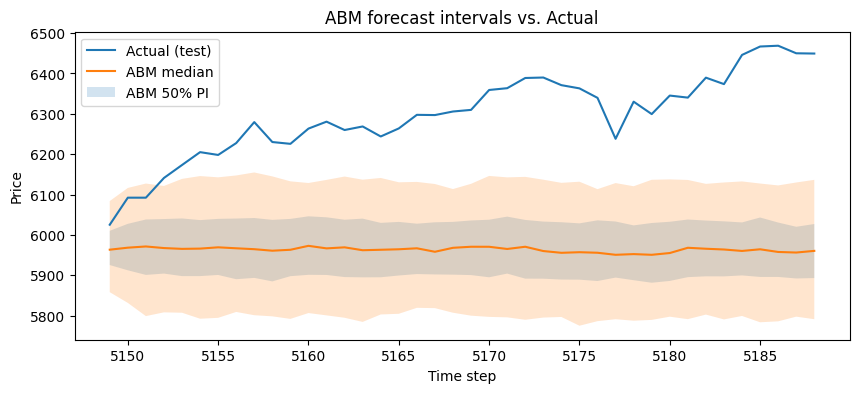

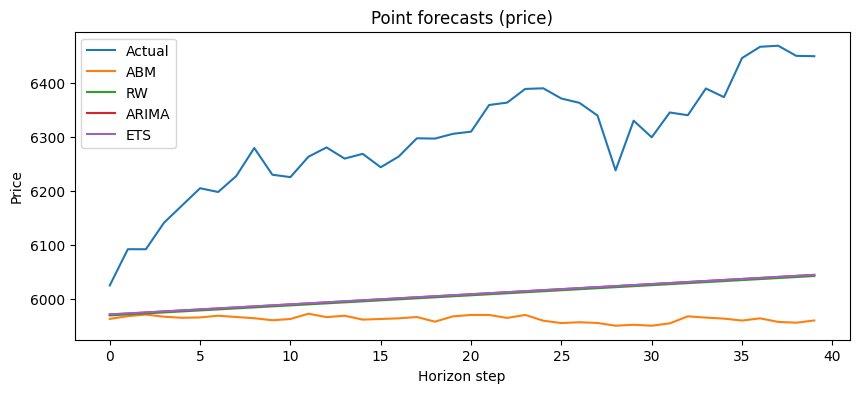

In [19]:
# Price with ABM intervals
plt.figure(figsize=(10,4))

x = np.arange(len(train_price), len(price))  # length H
y_actual = actual_price                      # length H
y_abm_med = abm_price_median[1:]             # drop initial p0 → length H

plt.plot(x, y_actual, label='Actual (test)')
plt.plot(x, y_abm_med, label='ABM median')

for cl in ABM_CONF_LEVELS:
    lo, hi = abm_intervals[cl]
    lo = np.asarray(lo)[1:]  # <-- drop initial p0
    hi = np.asarray(hi)[1:]  # <-- drop initial p0
    plt.fill_between(x, lo, hi, alpha=0.2, label=f'ABM {int(cl*100)}% PI' if cl == ABM_CONF_LEVELS[0] else None)

plt.title('ABM forecast intervals vs. Actual')
plt.xlabel('Time step')
plt.ylabel('Price')
plt.legend()
plt.show()

# Compare point forecasts (price)
plt.figure(figsize=(10,4))
plt.plot(actual_price, label='Actual')         # length H
for name, series in pf.items():
    plt.plot(series[1:], label=name)           # ensure all series are length H (series is H+1)
plt.title('Point forecasts (price)')
plt.xlabel('Horizon step')
plt.ylabel('Price')
plt.legend()
plt.show()


### Notes
- ABM intervals come from **Monte Carlo** and are naturally **probabilistic**.
- RW/ARIMA/ETS intervals rely on (often) Gaussian assumptions; real returns are heavy‑tailed.
- For more robust evaluation, run **rolling‑origin backtests** (can be added) and expand the moment set.
- You can crank up `ABM_MSM_RUNS`, `CMA_ITERS`, `OPTUNA_TRIALS`, and `ABM_MC_PATHS` for better calibration at the cost of runtime.